# **Otimização - Toy Experiment: Mitigação de Crosstalk**
## **Notebook de Otimização**

**Disciplina:** PPGEE0016 - Otimização

**Alunos:** André Paiva, Josias Souza, Victor Emanuel Paz

In [1]:
import sys
sys.path.insert(1, "../crosstalk/")

from time import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rc
import seaborn as sns

from functions import *
from XTconstants import *

sns.set_context("paper", font_scale=2.0)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [2]:
# Setting a random seed for reproducibility. Using a fixed seed value (5) ensures that the random numbers generated
# are the same across different runs of the code. This is important for verifying results, as it allows
# for consistent experimentation and comparison of outcomes.
np.random.seed(5)

In [3]:
df = pd.read_csv("./dataset/data.csv", index_col=0)
df

,E,E_x,timescale_clean,timescale_xt,delay_sampling,tau,tau_x,sampling_period,S_1,S_2,S_3,S_4
0,59412.274869,4792.422617,0.833459,1.861120,3.271603,56.08,17.28,25,36628.139188,56017.230291,46173.096004,25153.393190
1,51691.298481,4170.764452,1.143950,1.382774,0.838006,40.86,23.26,25,42583.959191,46295.148692,19792.438474,1969.545282
2,79307.711870,2246.259140,1.356987,1.596575,0.570604,34.45,20.14,25,70982.377518,58703.986365,14629.961111,-6061.920666
3,52479.078704,4630.296477,0.880730,0.904404,4.445942,53.07,35.56,25,38643.639887,54477.231823,36248.645619,14829.577108
4,56096.098416,4498.329215,0.904736,1.683603,1.502552,51.67,19.10,25,35661.076827,53261.092284,39592.473056,18641.196463
5,70824.811171,5018.137610,0.997951,1.563562,9.936060,46.84,20.57,25,65080.939470,60308.282475,30568.821270,7406.060652
6,45907.675951,3153.531383,1.099825,1.308271,1.251590,42.50,24.58,25,36393.960047,42532.755996,20105.789341,3432.312901
7,49083.633421,6520.807634,1.393039,1.093891,0.152014,33.56,29.40,25,49418.046108,37939.546587,5163.228465,-7620.700532
8,56876.032258,2767.613885,1.111740,1.379128,0.351508,42.05,23.32,25,42899.565257,52793.273566,25604.905899,4625.277914
9,51701.300422,4726.953261,1.321530,1.301246,3.113261,35.37,24.71,25,51237.094295,37428.393461,7576.081265,-5094.060715


In [4]:
def func_s(params, n, sampling_period=25):
    """
    Aproxima uma amostra do sinal contaminado por crosstalk.
    
    Parâmetros:
      params: dicionário contendo E, tau, E_x, tau_x e sample_delay.
      n: índice da amostra.
      sampling_period: intervalo entre amostras (padrão 25 ns).
      
    Retorna:
      Valor da amostra aproximada de acordo com os parâmetros.
    """
    # Aqui se assume que cellFunction e XTalk já estão definidas.
    clean_signal = params["E"] * cellFunction(sampling_period*(n+1)*46.74/params["tau"] + params["sample_delay"])
    xt_signal = params["E_x"] * XTalk(sampling_period*(n+1)*32.16/params["tau_x"] + params["sample_delay"])
    return clean_signal + xt_signal

In [5]:
def func_mse(samples, params, sampling_period=25):
    mse = 0
    for i in range(samples.shape[0]):
        mse += (samples[i] - func_s(params, i, sampling_period))**2
    mse /= samples.shape[0]
    return mse

In [6]:
def genetico(samples, funcao=func_mse, sampling_period=25, populacao=100, iteracoes=100, p_recomb=0.15, p_mutacao=0.05):
    # Inicialização da população
    E_init = np.abs(np.random.normal(loc=90000, scale=80000, size=populacao))
    tau_init = np.abs(np.random.normal(loc=60, scale=10, size=populacao))
    E_x_init = np.abs(np.random.normal(loc=9000, scale=8000, size=populacao))
    tau_x_init = np.abs(np.random.normal(loc=60, scale=10, size=populacao))
    samp_delay_init = np.abs(np.random.normal(loc=3, scale=4, size=populacao))
    x_matrix = np.stack([E_init, tau_init, E_x_init, tau_x_init, samp_delay_init], axis=1)
    
    avg_fitness = np.array([])
    min_fitness = np.array([])
    col = ['E', 'tau', 'E_x', 'tau_x', 'sample_delay', 'fitness', 'iter']
    df_evolution = pd.DataFrame(columns=col)
    
    x_pop = np.copy(x_matrix)
    time_init = time()
    best = {"E": -np.inf, "tau": -np.inf, "E_x": -np.inf, "tau_x": -np.inf, "sample_delay": -np.inf}
    
    for i in range(iteracoes):
        # Avaliação da população
        x_params = [{"E": candidato[0],
                     "tau": candidato[1],
                     "E_x": candidato[2],
                     "tau_x": candidato[3],
                     "sample_delay": candidato[4]} for candidato in x_pop]
        x_fitness = np.array([-funcao(samples, params, sampling_period) for params in x_params]).reshape(-1, 1)
        iter_atual = np.tile([i], x_pop.shape[0]).reshape(-1, 1)
        df_data = np.concatenate((x_pop, x_fitness, iter_atual), axis=1)
        df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)
        
        # Salvando as métricas de fitness
        avg_fitness = np.append(avg_fitness, np.mean(x_fitness))
        min_fitness = np.append(min_fitness, np.min(x_fitness))
        
        # Ordenação da população (fitness crescente)
        x_sort = np.argsort(x_fitness, axis=0).reshape(-1)
        x_fitness = x_fitness[x_sort]
        x_pop = x_pop[x_sort]
        best = {"E": x_pop[-1, 0],
                "tau": x_pop[-1, 1],
                "E_x": x_pop[-1, 2],
                "tau_x": x_pop[-1, 3],
                "sample_delay": x_pop[-1, 4]}
        
        # Probabilidade de seleção
        prob_num = np.array([np.sum(np.arange(1, i+1)) for i in range(1, x_pop.shape[0]+1)])
        prob_den = np.sum(np.arange(1, x_pop.shape[0]+1))
        prob = prob_num / prob_den
        
        # Seleção
        selecao_prob = np.random.rand(np.ceil(x_pop.shape[0]/2).astype(np.int32), 2)
        index_selecao_prob = np.searchsorted(prob, selecao_prob, side='right')
        
        # Recombinação
        new_pop = np.empty((0, x_pop.shape[1]))
        for j in index_selecao_prob:
            candidato1 = x_pop[j[0]]
            candidato2 = x_pop[j[1]]
            recomb_mask = np.random.rand(candidato1.shape[0]) <= p_recomb
            novo_candidato1 = np.where(recomb_mask, candidato2, candidato1).reshape((1, -1))
            novo_candidato2 = np.where(recomb_mask, candidato1, candidato2).reshape((1, -1))
            new_pop = np.concatenate((new_pop, novo_candidato1, novo_candidato2), axis=0)
        new_pop = new_pop[:x_pop.shape[0]]
        
        # Mutação
        E_init = np.abs(np.random.normal(loc=90000, scale=80000, size=populacao))
        tau_init = np.abs(np.random.normal(loc=60, scale=10, size=populacao))
        E_x_init = np.abs(np.random.normal(loc=9000, scale=8000, size=populacao))
        tau_x_init = np.abs(np.random.normal(loc=60, scale=10, size=populacao))
        samp_delay_init = np.abs(np.random.normal(loc=3, scale=4, size=populacao))
        mut_gen = np.stack([E_init, tau_init, E_x_init, tau_x_init, samp_delay_init], axis=1)
        mut_mask = np.random.rand(new_pop.shape[0], new_pop.shape[1]) <= p_mutacao
        new_pop = np.where(mut_mask, mut_gen, new_pop)
        
        # Atualiza população
        x_pop = np.copy(new_pop)
        
        # Última avaliação (se for a última iteração)
        if i == iteracoes - 1:
            x_params = [{"E": candidato[0],
                         "tau": candidato[1],
                         "E_x": candidato[2],
                         "tau_x": candidato[3],
                         "sample_delay": candidato[4]} for candidato in x_pop]
            x_fitness = np.array([-funcao(samples, params, sampling_period) for params in x_params]).reshape(-1, 1)
            iter_atual = np.tile([i], x_pop.shape[0]).reshape(-1, 1)
            df_data = np.concatenate((x_pop, x_fitness, iter_atual), axis=1)
            df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)
            avg_fitness = np.append(avg_fitness, np.mean(x_fitness))
            min_fitness = np.append(min_fitness, np.min(x_fitness))
    
    elapsed_time = (time() - time_init) * 1000  # tempo em milissegundos
    fitness_metrics = np.concatenate((avg_fitness.reshape(-1,1), min_fitness.reshape(-1,1)), axis=1)
    df_fitness = pd.DataFrame(fitness_metrics, columns=["avg_fitness", "min_fitness"])
    
    return best, df_evolution, df_fitness, elapsed_time

In [7]:
signal_index = np.random.randint(0, 99)
samples = np.array([df[f"S_{i}"][signal_index] for i in range(1, 5)])
best, df_evolution, df_fitness, elapsed_time = genetico(samples)

/tmp/ipykernel_108868/106432779.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)


In [8]:
df_est_comparison = pd.DataFrame(data=[["E", best["E"], df["E"][signal_index]],
                                 ["Tau", best["tau"], df["tau"][signal_index]],
                                 ["E_x", best["E_x"], df["E_x"][signal_index]],
                                 ["Tau_x", best["tau_x"], df["tau_x"][signal_index]],
                                 ["Sampling Delay", best["sample_delay"], df["delay_sampling"][signal_index]]],
                                 columns=["Parâmetro", "Estimado", "Esperado"])

df_est_comparison

,Parâmetro,Estimado,Esperado
0,E,41365.078417,49016.400666
1,Tau,56.099786,54.720000
2,E_x,5847.217328,5222.170557
3,Tau_x,76.840573,21.130000
4,Sampling Delay,5.239330,0.798953


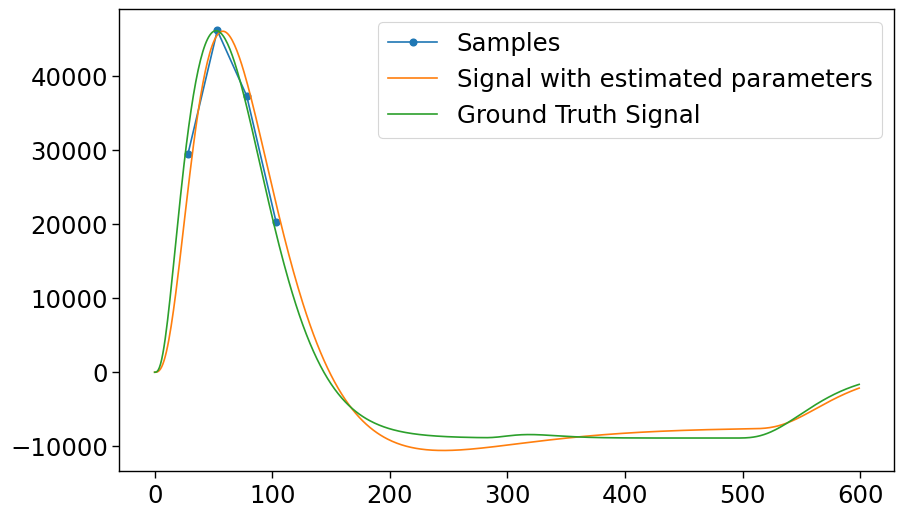

In [9]:
plt.plot([df["delay_sampling"][0] + 25,
          df["delay_sampling"][0] + 50,
          df["delay_sampling"][0] + 75,
          df["delay_sampling"][0] + 100], samples, marker='o', label="Samples")

ETrue_est = np.array([best["E"]*cellFunction(t*46.74/best["tau"]) for t in range(600)])
XT_est = np.array([best["E_x"]*XTalk(t*32.16/best["tau_x"]) for t in range(600)])
signal_est = ETrue_est + XT_est

ETrue_gt = np.array([df["E"][signal_index]*cellFunction(t*46.74/df["tau"][signal_index]) for t in range(600)])
XT_gt = np.array([df["E_x"][signal_index]*XTalk(t*32.16/df["tau_x"][signal_index]) for t in range(600)])
signal_gt = ETrue_gt + XT_gt

#Gráfico Comparativo
plt.plot(range(600), signal_est, label="Signal with estimated parameters")
plt.plot(range(600), signal_gt, label="Ground Truth Signal")
plt.legend()
plt.show()


/tmp/ipykernel_108868/106432779.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)
/tmp/ipykernel_108868/106432779.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_evolution = pd.concat([df_evolution, pd.DataFrame(df_data, columns=col)], ignore_index=True)
/tmp/ipykernel_108868/106432779.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. 

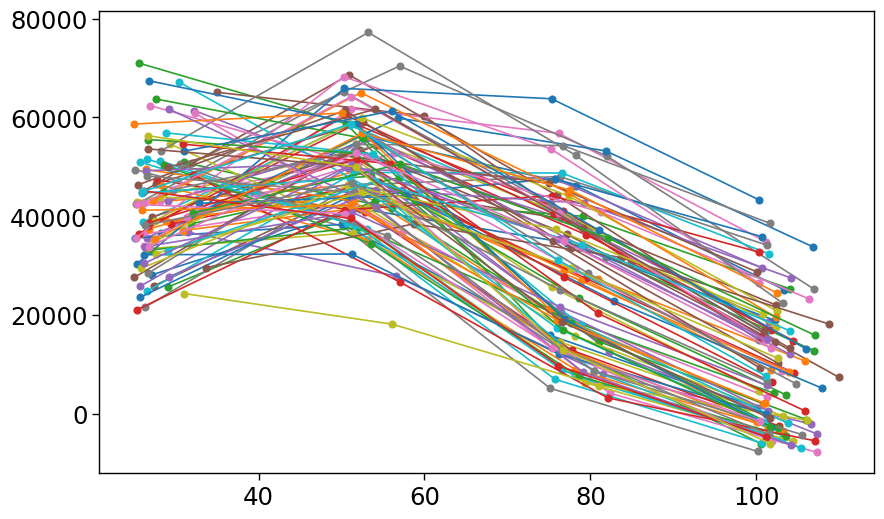

In [10]:
# Processar todos os sinais e gerar gráficos comparativos

df_comparison_list = []
for signal_index in range(100):
    samples = np.array([df[f"S_{i}"][signal_index] for i in range(1, 5)])
    best, df_evolution, df_fitness, elapsed_time = genetico(samples)
    
    df_est_comparison = pd.DataFrame(data=[["E", best["E"], df["E"][signal_index]],
                                           ["Tau", best["tau"], df["tau"][signal_index]],
                                           ["E_x", best["E_x"], df["E_x"][signal_index]],
                                           ["Tau_x", best["tau_x"], df["tau_x"][signal_index]],
                                           ["Sampling Delay", best["sample_delay"], df["delay_sampling"][signal_index]]],
                                     columns=["Parâmetro", "Estimado", "Esperado"])
    # Calcula o erro (diferença entre estimado e esperado)
    df_est_comparison["Erro"] = df_est_comparison["Estimado"] - df_est_comparison["Esperado"]
    # Adiciona uma coluna para identificar o sinal
    df_est_comparison["Sinal"] = signal_index + 1

    df_comparison_list.append(df_est_comparison)
    
    plt.plot([df["delay_sampling"][signal_index] + 25, df["delay_sampling"][signal_index] + 50, df["delay_sampling"][signal_index] + 75, df["delay_sampling"][signal_index] + 100], samples, marker='o', label="Samples")

    ETrue_est = np.array([best["E"]*cellFunction(t*46.74/best["tau"]) for t in range(600)])
    XT_est = np.array([best["E_x"]*XTalk(t*32.16/best["tau_x"]) for t in range(600)])
    signal_est = ETrue_est + XT_est

    ETrue_gt = np.array([df["E"][signal_index]*cellFunction(t*46.74/df["tau"][signal_index]) for t in range(600)])
    XT_gt = np.array([df["E_x"][signal_index]*XTalk(t*32.16/df["tau_x"][signal_index]) for t in range(600)])
    signal_gt = ETrue_gt + XT_gt

    # Gráfico Comparativo
    #plt.plot(range(600), signal_est, label="Signal with estimated parameters")
    #plt.plot(range(600), signal_gt, label="Ground Truth Signal")
    #plt.legend()
    #plt.show()

# Concatena todas as tabelas em um único DataFrame
df_comparison = pd.concat([table for table in df_comparison_list], ignore_index=True)

In [11]:
# Exibir as tabelas geradas
for index, comparison in enumerate(df_comparison_list):
    print(f"Tabela de Comparação para o Sinal {index + 1}")
    print(comparison)
    print("\n")

Tabela de Comparação para o Sinal 1
        Parâmetro      Estimado      Esperado         Erro  Sinal
0               E  50508.565208  59412.274869 -8903.709661      1
1             Tau     62.741905     56.080000     6.661905      1
2             E_x   6324.336878   4792.422617  1531.914261      1
3           Tau_x     55.864393     17.280000    38.584393      1
4  Sampling Delay      7.207172      3.271603     3.935569      1


Tabela de Comparação para o Sinal 2
        Parâmetro      Estimado      Esperado          Erro  Sinal
0               E  37023.451853  51691.298481 -14667.846628      2
1             Tau     46.524424     40.860000      5.664424      2
2             E_x  13644.039897   4170.764452   9473.275444      2
3           Tau_x     45.530449     23.260000     22.270449      2
4  Sampling Delay      6.738483      0.838006      5.900477      2


Tabela de Comparação para o Sinal 3
        Parâmetro      Estimado      Esperado          Erro  Sinal
0               E  6275

/tmp/ipykernel_108868/3407346590.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(["E", f"${{E_x}}$"])
/tmp/ipykernel_108868/3407346590.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels([r'$\tau$', r'$\tau_x$', "sample_delay"])


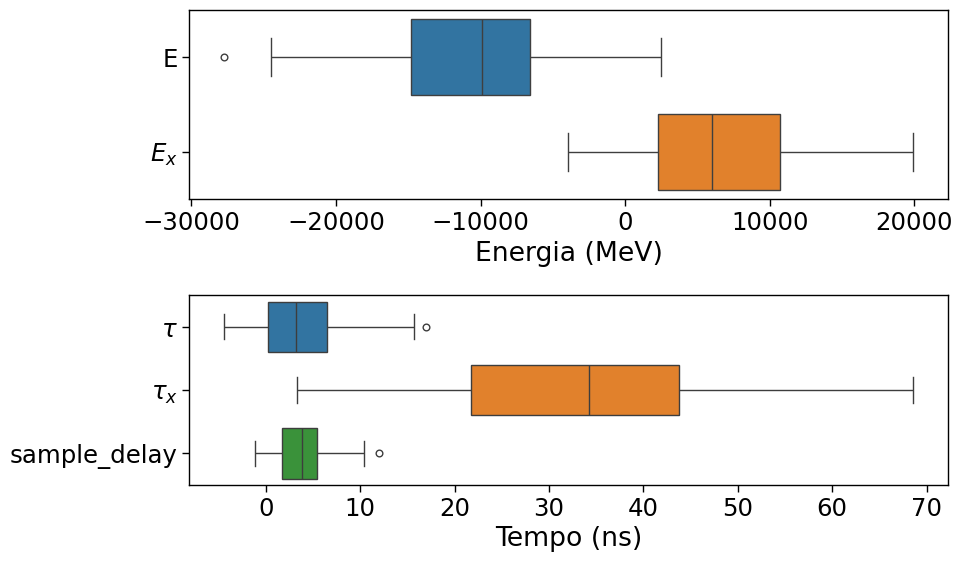

In [12]:
erro_e = df_comparison[(df_comparison['Parâmetro']=='E') | (df_comparison['Parâmetro']=='E_x')]

fig, ax = plt.subplots(2, 1, figsize=(10, 6))
sns.boxplot(data=erro_e, x="Erro", y="Parâmetro", ax=ax[0], hue="Parâmetro")

#ax[0].set_title("Erro de estimação de energia - Otimização Paralela")
ax[0].set_xlabel("Energia (MeV)")
ax[0].set_ylabel(None)
ax[0].set_yticklabels(["E", f"${{E_x}}$"])

erro_t = df_comparison[(df_comparison['Parâmetro']!='E') & (df_comparison['Parâmetro']!='E_x')]

sns.boxplot(data=erro_t, x="Erro", y="Parâmetro", ax=ax[1], hue="Parâmetro")
#ax[1].set_title("Erro de estimação de tempo - Otimização Paralela")
ax[1].set_xlabel("Tempo (ns)")
ax[1].set_ylabel(None)
ax[1].set_yticklabels([r'$\tau$', r'$\tau_x$', "sample_delay"])
plt.tight_layout()
fig.savefig("boxplot_individual.pdf")

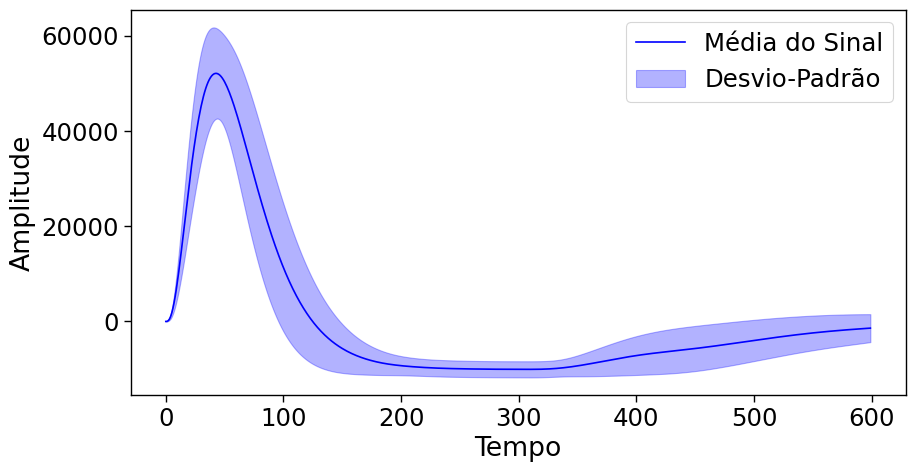

In [13]:
# Leitura do dataset
df = pd.read_csv("./dataset/data.csv", index_col=0)

def calcular_media_desvio(df):
    num_signals = 100
    num_timepoints = 600
    all_signals = np.zeros((num_signals, num_timepoints))
    
    for signal_index in range(num_signals):
        E = df["E"][signal_index]
        tau = df["tau"][signal_index]
        E_x = df["E_x"][signal_index]
        tau_x = df["tau_x"][signal_index]
        
        ETrue = np.array([E * cellFunction(t * 46.74 / tau) for t in range(num_timepoints)])
        XT = np.array([E_x * XTalk(t * 32.16 / tau_x) for t in range(num_timepoints)])
        signal = ETrue + XT
        
        all_signals[signal_index, :] = signal
    
    mean_signal = np.mean(all_signals, axis=0)
    std_signal = np.std(all_signals, axis=0)
    return mean_signal, std_signal

def plot_media_desvio(mean_signal, std_signal):
    timepoints = np.arange(len(mean_signal))
    plt.figure(figsize=(10, 5))
    plt.plot(timepoints, mean_signal, label='Média do Sinal', color='b')
    plt.fill_between(timepoints, mean_signal - std_signal, mean_signal + std_signal, color='b', alpha=0.3, label='Desvio-Padrão')
    plt.xlabel('Tempo')
    plt.ylabel('Amplitude')
    # plt.title('Média e Desvio-Padrão dos 100 Sinais')
    plt.legend()
    plt.show()

# Executando as funções
mean_signal, std_signal = calcular_media_desvio(df)
plot_media_desvio(mean_signal, std_signal)


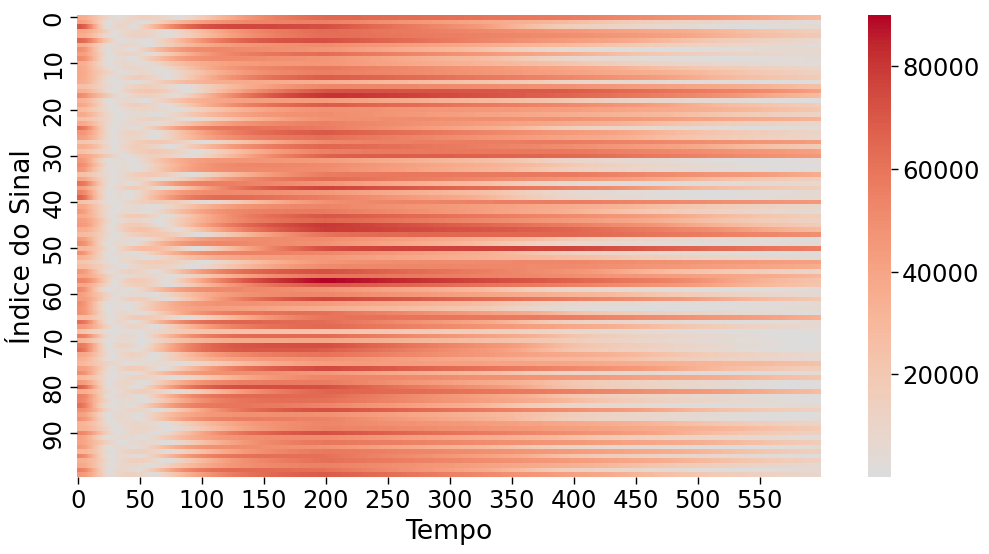

In [14]:
import seaborn as sns
def calcular_erro(df):
    num_signals = 100
    num_timepoints = 600
    erro_matriz = np.zeros((num_signals, num_timepoints))
    
    for signal_index in range(num_signals):
        E = df["E"][signal_index]
        tau = df["tau"][signal_index]
        E_x = df["E_x"][signal_index]
        tau_x = df["tau_x"][signal_index]
        
        ETrue = np.array([E * cellFunction(t * 46.74 / tau) for t in range(num_timepoints)])
        XT = np.array([E_x * XTalk(t * 32.16 / tau_x) for t in range(num_timepoints)])
        signal_gt = ETrue + XT
        
        # Simulação do sinal estimado (substituir pelos valores reais do seu modelo)
        signal_est = np.array([df[f"S_{i}"][signal_index] for i in range(1, 5)])
        signal_est = np.interp(np.arange(num_timepoints), np.linspace(0, num_timepoints-1, len(signal_est)), signal_est)
        
        erro_matriz[signal_index, :] = signal_gt - signal_est
    
    return erro_matriz

def plot_heatmap_erro(erro_matriz):
    plt.figure(figsize=(12, 6))
    sns.heatmap(np.abs(erro_matriz), cmap="coolwarm", center=0, cbar=True, xticklabels=50, yticklabels=10)
    plt.xlabel("Tempo")
    plt.ylabel("Índice do Sinal")
    # plt.title("Heatmap do Erro entre Sinal Estimado e Real")
    plt.show()

# Executando as funções
erro_matriz = calcular_erro(df)
plot_heatmap_erro(erro_matriz)